### Import Libraries

In [40]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_context('talk', font_scale = 1.05)

### Data Upload

In [41]:
# Files
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county'
df_mask_use = pd.read_csv(url +'.csv')
df_confirmed_cases = pd.read_csv('RAW_us_confirmed_cases.csv')
df_mask_mandate = pd.read_csv('masking_mandates_by_county.csv')

In [42]:
# Constants
county, state = 'Multnomah', 'Oregon'
start_date, end_date = '2020-02-01', '2021-10-01'
population_apr20, population_jul21 = 815428, 803377

### Data Cleaning

**1. df_mask_mandate**

In [43]:
# Process rows: filter & reset index
df_mask_mandate['County_Name'] = df_mask_mandate['County_Name'].str.rstrip('County ')
df_mask_mandate = df_mask_mandate[df_mask_mandate['County_Name'].isin([county])]

df_mask_mandate.date = pd.to_datetime(df_mask_mandate.date)
df_mask_mandate = df_mask_mandate[(df_mask_mandate['date'] >= start_date) & (df_mask_mandate['date'] <= end_date)]
df_mask_mandate.reset_index(drop = True, inplace = True)


# Process columns: create new cols & convert datatypes
def policy(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return -1
    
df_mask_mandate['mask_mandate'] = df_mask_mandate['Face_Masks_Required_in_Public'].apply(lambda x: policy(x))
df_mask_mandate['fips_county'] = df_mask_mandate['FIPS_State'].astype('str')+'0'+df_mask_mandate['FIPS_County'].astype('str')
fips_list = df_mask_mandate.fips_county.drop_duplicates().to_list()

# Drop unecessary columns & sort
df_mask_mandate.drop(columns = ['State_Tribe_Territory',
                                'FIPS_State',
                                'County_Name',
                                'FIPS_County',
                                'URL',
                                'Citation',
                                'order_code', 
                                'Face_Masks_Required_in_Public'], inplace = True)

df_mask_mandate = df_mask_mandate[['fips_county', 'date', 'mask_mandate', 'Source_of_Action']]

df_mask_mandate.head()

,fips_county,date,mask_mandate,Source_of_Action
0,41051,2020-04-11,-1,NaN
1,41051,2020-04-12,-1,NaN
2,41051,2020-04-13,-1,NaN
3,41051,2020-04-10,-1,NaN
4,41051,2020-04-14,-1,NaN


**2. df_mask_use**

In [44]:
# Process columns: create new cols & convert datatypes
df_mask_use.rename(columns = {'COUNTYFP':'fips_county'}, inplace = True)
df_mask_use.fips_county = df_mask_use.fips_county.astype('str')
df_mask_use.columns = df_mask_use.columns.str.lower()

# Process rows: filter & reset index
df_mask_use = df_mask_use[df_mask_use['fips_county'].isin(fips_list)]
df_mask_use.reset_index(drop = True, inplace = True)

df_mask_use.head()

,fips_county,never,rarely,sometimes,frequently,always
0,41051,0.013,0.016,0.054,0.178,0.738


**3. df_confirmed_cases**

In [45]:
# Drop unecessary columns & rename needed
df_confirmed_cases.drop(columns = ['UID', 'iso2', 'iso3', 'code3','Country_Region', 'Combined_Key','Lat','Long_'], 
                        inplace = True)
df_confirmed_cases.rename(columns = {'Province_State': 'state',
                                     'Admin2': 'county',
                                     'FIPS': 'fips_county'}, inplace = True)

# Process rows: remove nulls, filter, un-pivot & reset index
df_confirmed_cases.dropna(subset = ['fips_county'], inplace = True)
df_confirmed_cases.fips_county = df_confirmed_cases.fips_county.astype('int').astype('str')
df_confirmed_cases = df_confirmed_cases[df_confirmed_cases.fips_county.isin(fips_list)]
df_confirmed_cases.reset_index(drop = True, inplace = True)

id_vars = ['state','county','fips_county']
df_confirmed_cases = pd.melt(df_confirmed_cases, id_vars = id_vars, var_name = 'date', value_name = 'case_count')

df_confirmed_cases.date = pd.to_datetime(df_confirmed_cases.date)
df_confirmed_cases = df_confirmed_cases[(df_confirmed_cases['date'] >= start_date) & (df_confirmed_cases['date'] <= end_date)]
df_confirmed_cases.reset_index(drop = True, inplace = True)
df_confirmed_cases['population'] = df_confirmed_cases['date'].apply(lambda x: 
                                                                    population_apr20 if x < datetime.strptime('2021-07-01', 
                                                                                                              '%Y-%m-%d') 
                                                                    else population_jul21)

df_confirmed_cases = df_confirmed_cases[['fips_county','state','county','date','case_count','population']]

df_confirmed_cases.head()

,fips_county,state,county,date,case_count,population
0,41051,Oregon,Multnomah,2020-02-01,0,815428
1,41051,Oregon,Multnomah,2020-02-02,0,815428
2,41051,Oregon,Multnomah,2020-02-03,0,815428
3,41051,Oregon,Multnomah,2020-02-04,0,815428
4,41051,Oregon,Multnomah,2020-02-05,0,815428


**4. Merge**

In [49]:
data = pd.merge(df_confirmed_cases, df_deaths, on = ['fips_county','date','state','county'], how = 'left')
data = pd.merge(data, df_mask_mandate, on = ['fips_county','date'], how = 'left')
data['mask_mandate'].fillna(-1, inplace = True)
data['mask_mandate'] = data['mask_mandate'].astype('int')
data.head()

,fips_county,state,county,date,case_count,population,death_count,mask_mandate,Source_of_Action
0,41051,Oregon,Multnomah,2020-02-01,0,815428,0,-1,NaN
1,41051,Oregon,Multnomah,2020-02-02,0,815428,0,-1,NaN
2,41051,Oregon,Multnomah,2020-02-03,0,815428,0,-1,NaN
3,41051,Oregon,Multnomah,2020-02-04,0,815428,0,-1,NaN
4,41051,Oregon,Multnomah,2020-02-05,0,815428,0,-1,NaN


### Analysis

**Plot 1: Trend of Confirmed cases**

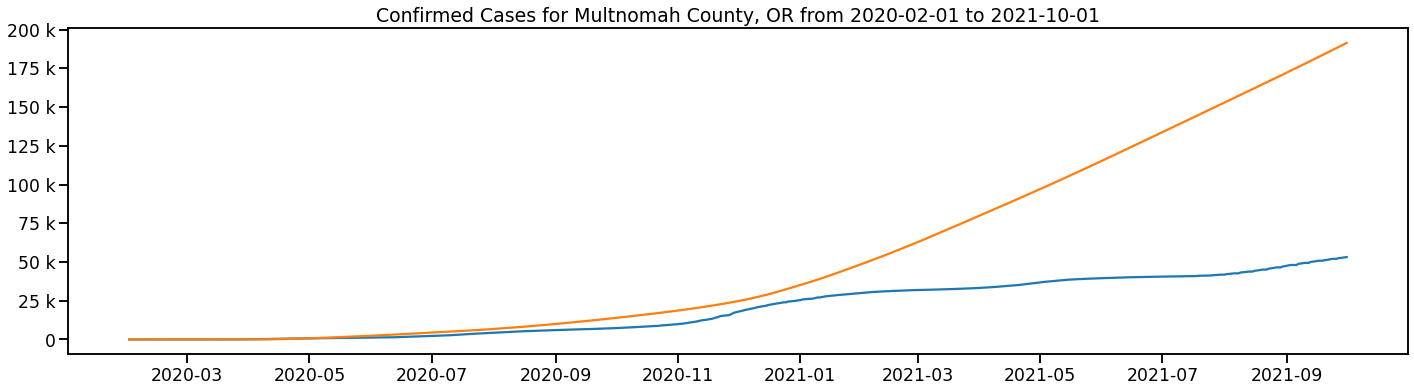

In [63]:
fig = plt.subplots(figsize = (24, 6))
g = sns.lineplot(x = 'date', y = 'case_count', data = data)
g.set(title = 'Confirmed Cases for Multnomah County, OR from 2020-02-01 to 2021-10-01', xlabel = '', ylabel = '')
g.yaxis.set_major_formatter(ticker.EngFormatter())
plt.show()

**Plot 2: Understanding Masking Policy Timeline**

**mask_mandate** values:
- +1: Policy Implemented     - face masks are required
-  $\space$ 0: No Policy Implemented  - face masks are NOT required
- $\space$-1: Unknown                - data regarding policy implementation is unknown

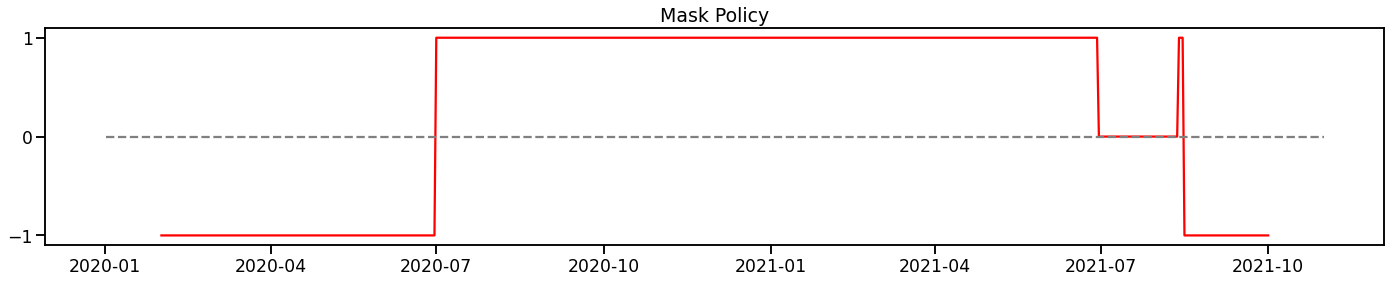

In [64]:
# Set a hashed-line function:
def abline(slope, intercept, style, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, style, color = color)

fig = plt.subplots(figsize = (24, 4))
g = sns.lineplot(x = 'date', y = 'mask_mandate', color = 'r', data = data)
g.set(title = 'Mask Policy', xlabel = '', ylabel = '', yticks = [-1,0,1])
abline(0,0,'--','gray')
plt.show()

### BIG Assumption:

- Before July 2020, masking mandates were actually not put in place - so we can essentially consider it 0. 
- After August 2021 too - we can consider masking mandate to be 0

In [65]:
data['mask_mandate'] = data['mask_mandate'].apply(lambda x: 0 if x == -1 else x)

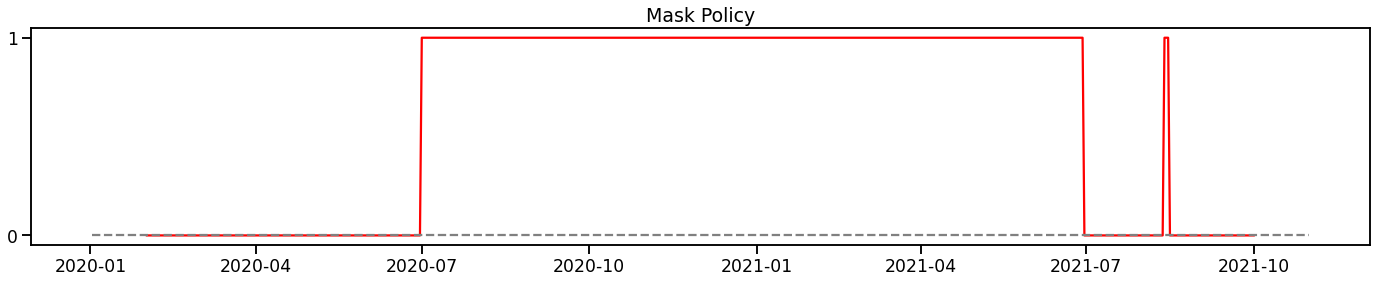

In [66]:
fig = plt.subplots(figsize = (24, 4))
g = sns.lineplot(x = 'date', y = 'mask_mandate', color = 'r', data = data)
g.set(title = 'Mask Policy', xlabel = '', ylabel = '', yticks = [-1,0,1])
abline(0,0,'--','gray')
plt.show()

**Plot 3: Viewing Trend of Confirmed Cases with Masking Policy**

In [67]:
data['prev_mask_mandate'] = data['mask_mandate'].shift(1).fillna(0).astype('int')
data['policy_change'] = data[['mask_mandate','prev_mask_mandate']].apply(lambda x: 1 if x[0] != x[1] else 0, axis = 1)
data.drop(columns = 'prev_mask_mandate', inplace = True)

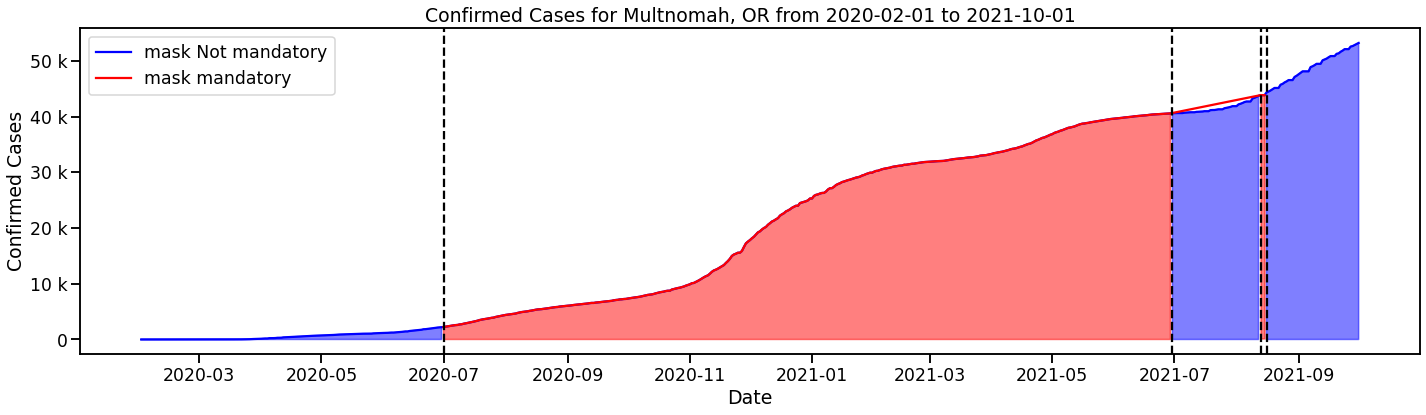

In [68]:
plt.subplots(figsize = (24, 6))

d1 = data.loc[data['mask_mandate'] == 1,]
g = sns.lineplot(x = 'date', y = 'case_count', data = data, color = 'b', label = 'mask Not mandatory')
g = sns.lineplot(x = 'date', y = 'case_count', data = d1, color = 'r', label = 'mask mandatory')
g.fill_between(data['date'], data['case_count'], alpha=0.5, color = 'b', where = data['mask_mandate'] == 0)
g.fill_between(data['date'], data['case_count'], alpha=0.5, color = 'r', where = data['mask_mandate'] == 1)
g.set(title = 'Confirmed Cases for Multnomah, OR from 2020-02-01 to 2021-10-01', xlabel = 'Date', ylabel = 'Confirmed Cases')
g.yaxis.set_major_formatter(ticker.EngFormatter())

for d in data.loc[data['policy_change'] == 1,['date']]['date'].dt.date:
    plt.axvline(d, color = 'black', linestyle = '--')

fig = g.get_figure()
fig.savefig('Confirmed Cases for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')

plt.show()

**Plot 4: Trend of Change in confirmed cases with Masking Policy**

In [188]:
# Extract increase in confirmed cases (current - previous) count
data.sort_values(by = 'date', inplace = True)
data['delta_over_last'] = data['case_count'] - data['case_count'].shift(1).fillna(0)

In [76]:
data['infection_rate'] = data['case_count'] / (data['population'] - data['case_count'])

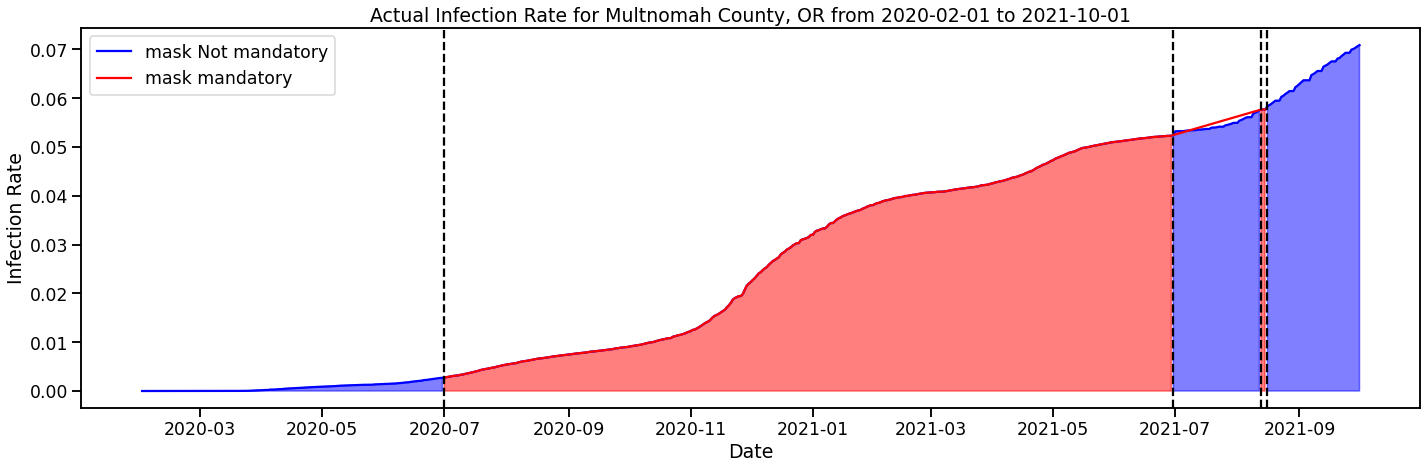

In [78]:
fig = plt.subplots(figsize = (24, 7))

d1 = data.loc[data['mask_mandate'] == 1,]
g = sns.lineplot(x = 'date', y = 'infection_rate', data = data, color = 'b', label = 'mask Not mandatory')
g = sns.lineplot(x = 'date', y = 'infection_rate', data = d1, color = 'r', label = 'mask mandatory')

g.fill_between(data['date'], data['infection_rate'], alpha=0.5, color = 'b', where = data['mask_mandate'] == 0)
g.fill_between(data['date'], data['infection_rate'], alpha=0.5, color = 'r', where = data['mask_mandate'] == 1)
g.set(title = 'Actual Infection Rate for Multnomah County, OR from 2020-02-01 to 2021-10-01', 
      xlabel = 'Date', ylabel = 'Infection Rate')
# g.yaxis.set_major_formatter(ticker.EngFormatter())

for d in data.loc[data['policy_change'] == 1,['date']]['date'].dt.date:
    plt.axvline(d, color = 'black', linestyle = '--')

fig = g.get_figure()
fig.savefig('Actual Infection Rate for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')
    
plt.show()

In [79]:
# Extract increase in infection rate (current - previous) count
data.sort_values(by = 'date', inplace = True)
data['infect_rate_delta'] = data['infection_rate'] - data['infection_rate'].shift(1).fillna(0)

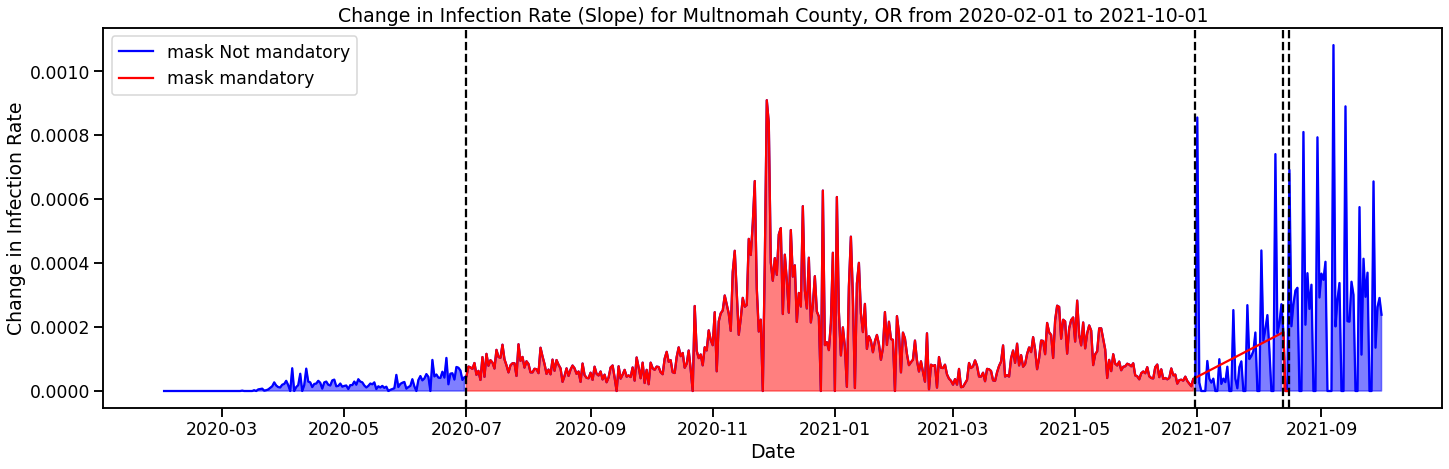

In [82]:
fig = plt.subplots(figsize = (24, 7))

d1 = data.loc[data['mask_mandate'] == 1,]
g = sns.lineplot(x = 'date', y = 'infect_rate_delta', data = data, color = 'b', label = 'mask Not mandatory')
g = sns.lineplot(x = 'date', y = 'infect_rate_delta', data = d1, color = 'r', label = 'mask mandatory')

g.fill_between(data['date'], data['infect_rate_delta'], alpha=0.5, color = 'b', where = data['mask_mandate'] == 0)
g.fill_between(data['date'], data['infect_rate_delta'], alpha=0.5, color = 'r', where = data['mask_mandate'] == 1)
g.set(title = 'Change in Infection Rate (Slope) for Multnomah County, OR from 2020-02-01 to 2021-10-01', 
      xlabel = 'Date', ylabel = 'Change in Infection Rate')
# g.yaxis.set_major_formatter(ticker.EngFormatter())

for d in data.loc[data['policy_change'] == 1,['date']]['date'].dt.date:
    plt.axvline(d, color = 'black', linestyle = '--')

fig = g.get_figure()
fig.savefig('Change in Infection Rate for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')

plt.show()

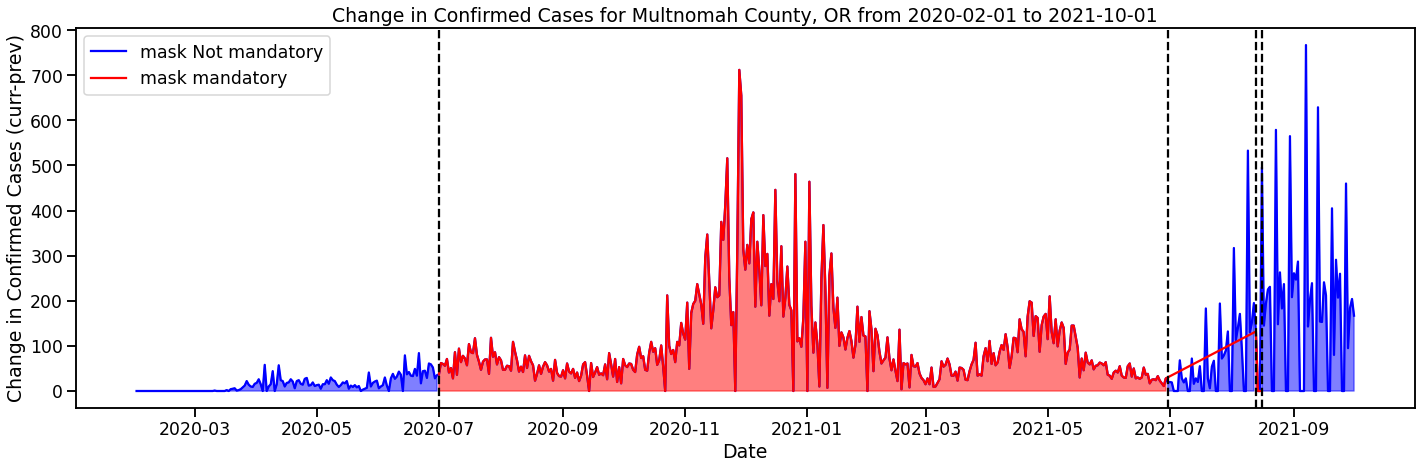

In [197]:
fig = plt.subplots(figsize = (24, 7))

d1 = data.loc[data['mask_mandate'] == 1,]
g = sns.lineplot(x = 'date', y = 'delta_over_last', data = data, color = 'b', label = 'mask Not mandatory')
g = sns.lineplot(x = 'date', y = 'delta_over_last', data = d1, color = 'r', label = 'mask mandatory')

g.fill_between(data['date'], data['delta_over_last'], alpha=0.5, color = 'b', where = data['mask_mandate'] == 0)
g.fill_between(data['date'], data['delta_over_last'], alpha=0.5, color = 'r', where = data['mask_mandate'] == 1)
g.set(title = 'Change in Confirmed Cases for Multnomah County, OR from 2020-02-01 to 2021-10-01', 
      xlabel = 'Date', ylabel = 'Change in Confirmed Cases (curr-prev)')
g.yaxis.set_major_formatter(ticker.EngFormatter())

for d in data.loc[data['policy_change'] == 1,['date']]['date'].dt.date:
    plt.axvline(d, color = 'black', linestyle = '--')

fig = g.get_figure()
fig.savefig('Change in Confirmed Cases for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')

    
plt.show()

**Plot 5: Change in Slope over time with Masking Policy**

In [192]:
# Extract change in change of confirmed cases (current - previous) change
data.sort_values(by = 'date', inplace = True)
data['delta2_over_last'] = data['delta_over_last'] - data['delta_over_last'].shift(1).fillna(0)

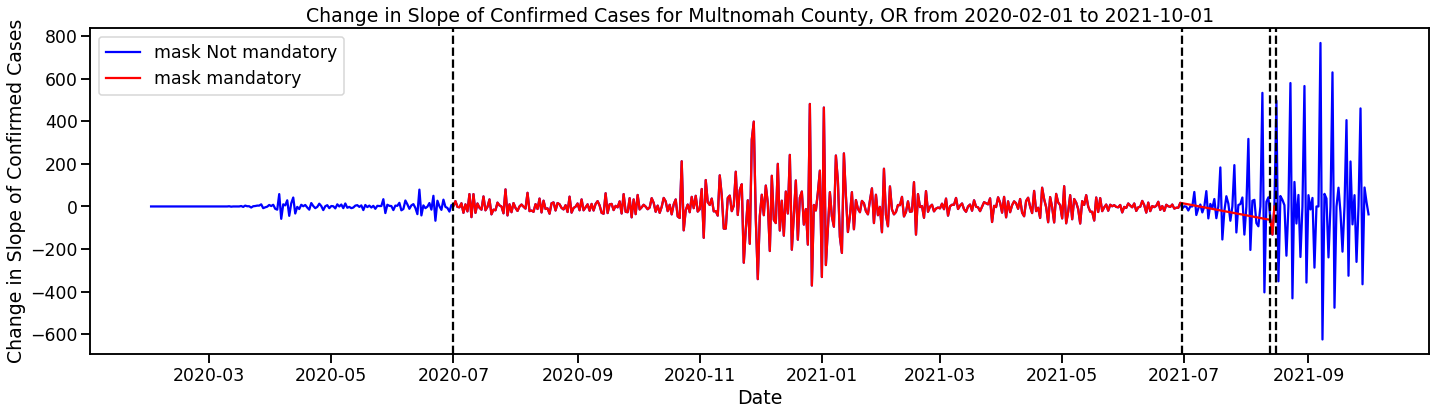

In [199]:
fig = plt.subplots(figsize = (24, 6))
d1 = data.loc[data['mask_mandate'] == 1,]
g = sns.lineplot(x = 'date', y = 'delta2_over_last', data = data, color = 'b', label = 'mask Not mandatory')
g = sns.lineplot(x = 'date', y = 'delta2_over_last', data = d1, color = 'r', label = 'mask mandatory')
g.set(title = 'Change in Slope of Confirmed Cases for Multnomah County, OR from 2020-02-01 to 2021-10-01', 
      xlabel = 'Date', ylabel = 'Change in Slope of Confirmed Cases')
g.yaxis.set_major_formatter(ticker.EngFormatter())

for d in data.loc[data['policy_change'] == 1,['date']]['date'].dt.date:
    plt.axvline(d, color = 'black', linestyle = '--')

fig = g.get_figure()
fig.savefig('Change in Slope of Confirmed Cases for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')

plt.show()

### Checking Autocorrelation

In [24]:
import statsmodels.tsa as tsa
import statsmodels.graphics.tsaplots as tsaplots

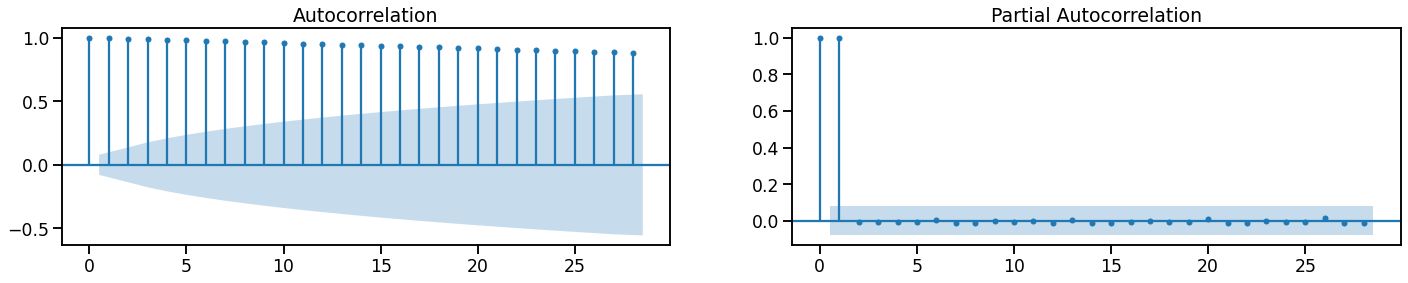

PACF Coefficients: [ 1.          0.99754782 -0.00583804]


<Figure size 432x288 with 0 Axes>

In [205]:
# Plot ACF & PACF:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 4))
g = tsaplots.plot_acf(data['case_count'], ax = ax[0])
g = tsaplots.plot_pacf(data['case_count'], ax = ax[1])
plt.show()
print(f"PACF Coefficients: {tsa.stattools.pacf(x = data['case_count'], nlags = 2)}")

plt.savefig('Autoregression Plots of Confirmed Cases for Multnomah, OR from 2020-02-01 to 2021-10-01.jpg')

**Conclusion:**
- We see a direct positive effect of outcome lagged 1 time period on the current outcome. This *direct* effect is established by the PACF plot.
- The partial autocorrelation coefficient of $a_{t-1}$ on $a_{t}$ is approx. $0.9975$.
- This is an Autoregressive process with order 1 lag 1. $AR(1)$ with $\phi_{1} = 0.9975$ (*approx.*)
- <u>Stationarity:</u> The autocorrelation coefficient at lag 1 is very close to 1. Moreover, there is no statistically significant autocorrelation from any other lagged terms to revert this impact. This shows that the past has a very high impact on the present for a prolonged duration which results in greater accumulation of history and can affect the mean and variance of the series. Hence, we have strong evidences to think the series is non-stationary.

### ARIMA Models

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Set parameters of AR(1) process
ytimeseries = data['case_count']
xcovariates = data[['mask_mandate']]

# Build an ARIMA(p, d, q) model representing AR(1) process
ar1_model = ARIMA(endog = np.asarray(ytimeseries), 
                  order = (1, 0, 0),                         # AR(1) process
                  exog = np.asarray(xcovariates)).fit()

In [31]:
ar1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  609
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3878.212
Date:                Thu, 03 Nov 2022   AIC                           7764.424
Time:                        13:11:33   BIC                           7782.072
Sample:                             0   HQIC                          7771.290
                                - 609                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.741e+04    1.6e-20   1.09e+24      0.000    1.74e+04    1.74e+04
x1           -84.4185   1.72e-19   -4.9e+20      0.000     -84.418     -84.418
ar.L1          1.0000   2.62e-07   3.81e+06      0.000       1.000       1.000
sigma2      1.938e+04   1.83e-18   1.06e+22      0.000    1.94e+04    1.94e+04
===================================================================================
Ljung-Box (L1) (Q):                 149.82   Jarque-Bera (JB):              2416.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.12   Skew:                             2.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.86e+40. Standard errors may be unstable.
"""